<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preperation" data-toc-modified-id="Data-preperation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preperation</a></span></li><li><span><a href="#Create-the-network" data-toc-modified-id="Create-the-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create the network</a></span><ul class="toc-item"><li><span><a href="#Prepare-Nodes-(Bike-Stations)" data-toc-modified-id="Prepare-Nodes-(Bike-Stations)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Prepare Nodes (Bike Stations)</a></span></li><li><span><a href="#Prepare-Edges-(Bike-Trips)" data-toc-modified-id="Prepare-Edges-(Bike-Trips)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Prepare Edges (Bike Trips)</a></span></li></ul></li><li><span><a href="#Build-the-network" data-toc-modified-id="Build-the-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build the network</a></span><ul class="toc-item"><li><span><a href="#Plot-all-nodes" data-toc-modified-id="Plot-all-nodes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot all nodes</a></span></li><li><span><a href="#Plot-topN-nodes" data-toc-modified-id="Plot-topN-nodes-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot topN nodes</a></span></li></ul></li><li><span><a href="#Analyze-the-network" data-toc-modified-id="Analyze-the-network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyze the network</a></span><ul class="toc-item"><li><span><a href="#Basic-concepts-and-definitions" data-toc-modified-id="Basic-concepts-and-definitions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Basic concepts and definitions</a></span></li></ul></li></ul></div>

# Bike Network Analysis

## Data preperation

In [1]:
# import modules
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("poster")
%matplotlib inline

In [2]:
# read data
path_to_data = "../data/NYC-CitiBike-2016.csv"
df = pd.read_csv(path_to_data)
df.columns = df.columns.str.replace(" ", "_")
df = df[(df["start_station_latitude"]!=0) & 
        (df["start_station_longitude"]!=0) &
        (df["end_station_latitude"]!=0) & 
        (df["end_station_longitude"]<0)]
df.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender
count,2.767950e+05,276795.000000,276795.000000,276795.000000,276795.000000,276795.000000,276795.000000,276795.000000,245137.000000,276795.000000
mean,9.479497e+02,1066.610430,40.737666,-73.986233,1049.060688,40.737353,-73.986447,21015.039163,1977.683385,1.099214
std,6.225612e+03,1185.227275,0.024515,0.016319,1174.287334,0.024377,0.016365,3616.249248,11.707865,0.568283
min,6.100000e+01,72.000000,40.445350,-74.017134,72.000000,40.445350,-74.033759,14529.000000,1885.000000,0.000000
25%,3.820000e+02,339.000000,40.720828,-73.997249,336.000000,40.720664,-73.997901,17852.000000,1970.000000,1.000000
50%,6.310000e+02,465.000000,40.739017,-73.988084,462.000000,40.739017,-73.988557,21263.000000,1980.000000,1.000000
75%,1.070000e+03,2003.000000,40.755003,-73.977225,546.000000,40.754666,-73.977387,24016.000000,1987.000000,1.000000
max,2.363758e+06,3440.000000,40.804213,-73.929891,3440.000000,40.804213,-73.929891,27327.000000,2000.000000,2.000000


## Create the network
Nodes = Stations
Edges = Trips

### Prepare Nodes (Bike Stations)

In [3]:
start_station_coord = df[["start_station_id", 
                          "start_station_name", 
                          "start_station_latitude", 
                          "start_station_longitude"]].\
                        drop_duplicates().\
                        rename(columns={"start_station_id": "id",
                                  "start_station_name": "name",
                                  "start_station_latitude": "lat",
                                  "start_station_longitude": "long"})

end_station_coord = df[["end_station_id", 
                        "end_station_name",
                        "end_station_latitude", 
                        "end_station_longitude"]].\
                        drop_duplicates(). \
                        rename(columns={"end_station_id": "id",
                                        "end_station_name": "name",
                                        "end_station_latitude": "lat",
                                        "end_station_longitude": "long"})

stations = pd.concat([start_station_coord, end_station_coord]).\
                        drop_duplicates(subset="id").\
                        sort_values("id").\
                        set_index("id")
stations.head()

,name,lat,long
id,,,
72,W 52 St & 11 Ave,40.767272,-73.993929
79,Franklin St & W Broadway,40.719116,-74.006667
82,St James Pl & Pearl St,40.711174,-74.000165
83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
116,W 17 St & 8 Ave,40.741776,-74.001497


In [4]:
stations["pos"] = list(zip(stations["lat"], 
                           stations["long"]))

nodes_pos = stations["pos"].\
        drop_duplicates().\
        to_dict()
nodes_pos

{72: (40.76727216, -73.99392888),
 79: (40.71911552, -74.00666661),
 82: (40.71117416, -74.00016545),
 83: (40.68382604, -73.97632328),
 116: (40.74177603, -74.00149746),
 119: (40.69608941, -73.97803415),
 120: (40.68676793, -73.95928168),
 127: (40.73172428, -74.00674436),
 128: (40.72710258, -74.00297088),
 137: (40.761628, -73.972924),
 143: (40.69239502, -73.99337909),
 144: (40.69839895, -73.98068914),
 146: (40.71625008, -74.0091059),
 147: (40.71542197, -74.01121978),
 150: (40.720873600000004, -73.98085795),
 151: (40.72210378668603, -73.99724900722505),
 152: (40.71473993, -74.00910627),
 153: (40.752062306999996, -73.9816324043),
 157: (40.69089272, -73.99612349),
 160: (40.748238, -73.978311),
 161: (40.72917025, -73.99810231),
 164: (40.75323098, -73.97032517),
 167: (40.7489006, -73.97604882),
 168: (40.73971301, -73.99456405),
 173: (40.76068327096592, -73.98452728986742),
 174: (40.7381765, -73.97738662),
 195: (40.70905623, -74.01043382),
 212: (40.74334935, -74.006817

In [5]:
pd.DataFrame(nodes_pos).T.describe()

,0,1
count,646.000000,646.000000
mean,40.727339,-73.978664
std,0.035589,0.020367
min,40.646678,-74.033759
25%,40.696125,-73.993895
50%,40.724468,-73.980972
75%,40.754590,-73.962140
max,40.804213,-73.929891


### Prepare Edges (Bike Trips)

In [6]:
trips = df[['tripduration', 'starttime', 'stoptime', 'start_station_id', 'end_station_id']]
trips.head()

,tripduration,starttime,stoptime,start_station_id,end_station_id
0,839,1/1/2016 00:09:55,1/1/2016 00:23:54,532,401
1,686,1/1/2016 00:21:17,1/1/2016 00:32:44,3143,3132
2,315,1/1/2016 00:33:11,1/1/2016 00:38:26,3164,3178
3,739,1/1/2016 00:40:51,1/1/2016 00:53:11,223,276
4,1253,1/1/2016 00:44:16,1/1/2016 01:05:09,484,151


In [7]:
edges = list(zip(trips["start_station_id"],
                 trips["end_station_id"]))
edges

[(532, 401),
 (3143, 3132),
 (3164, 3178),
 (223, 276),
 (484, 151),
 (474, 470),
 (387, 377),
 (223, 236),
 (3071, 3072),
 (379, 476),
 (152, 410),
 (293, 394),
 (358, 236),
 (339, 251),
 (3123, 3120),
 (268, 342),
 (483, 293),
 (524, 474),
 (293, 296),
 (250, 432),
 (306, 439),
 (537, 453),
 (3076, 336),
 (410, 394),
 (479, 448),
 (236, 532),
 (164, 527),
 (380, 545),
 (3087, 3060),
 (151, 531),
 (324, 340),
 (492, 524),
 (387, 238),
 (3112, 3105),
 (331, 317),
 (151, 251),
 (527, 228),
 (3166, 448),
 (3166, 281),
 (487, 279),
 (458, 335),
 (341, 295),
 (363, 146),
 (3139, 3163),
 (504, 507),
 (3054, 409),
 (3124, 3119),
 (3164, 228),
 (3166, 3165),
 (161, 428),
 (302, 519),
 (3147, 2006),
 (3089, 2002),
 (380, 250),
 (248, 229),
 (281, 3145),
 (3107, 3101),
 (453, 345),
 (3142, 3156),
 (224, 398),
 (513, 499),
 (344, 306),
 (334, 336),
 (254, 363),
 (368, 3178),
 (391, 325),
 (281, 499),
 (284, 161),
 (3145, 3148),
 (265, 455),
 (301, 300),
 (505, 410),
 (524, 3226),
 (303, 352),
 (

## Build the network

### Plot all nodes

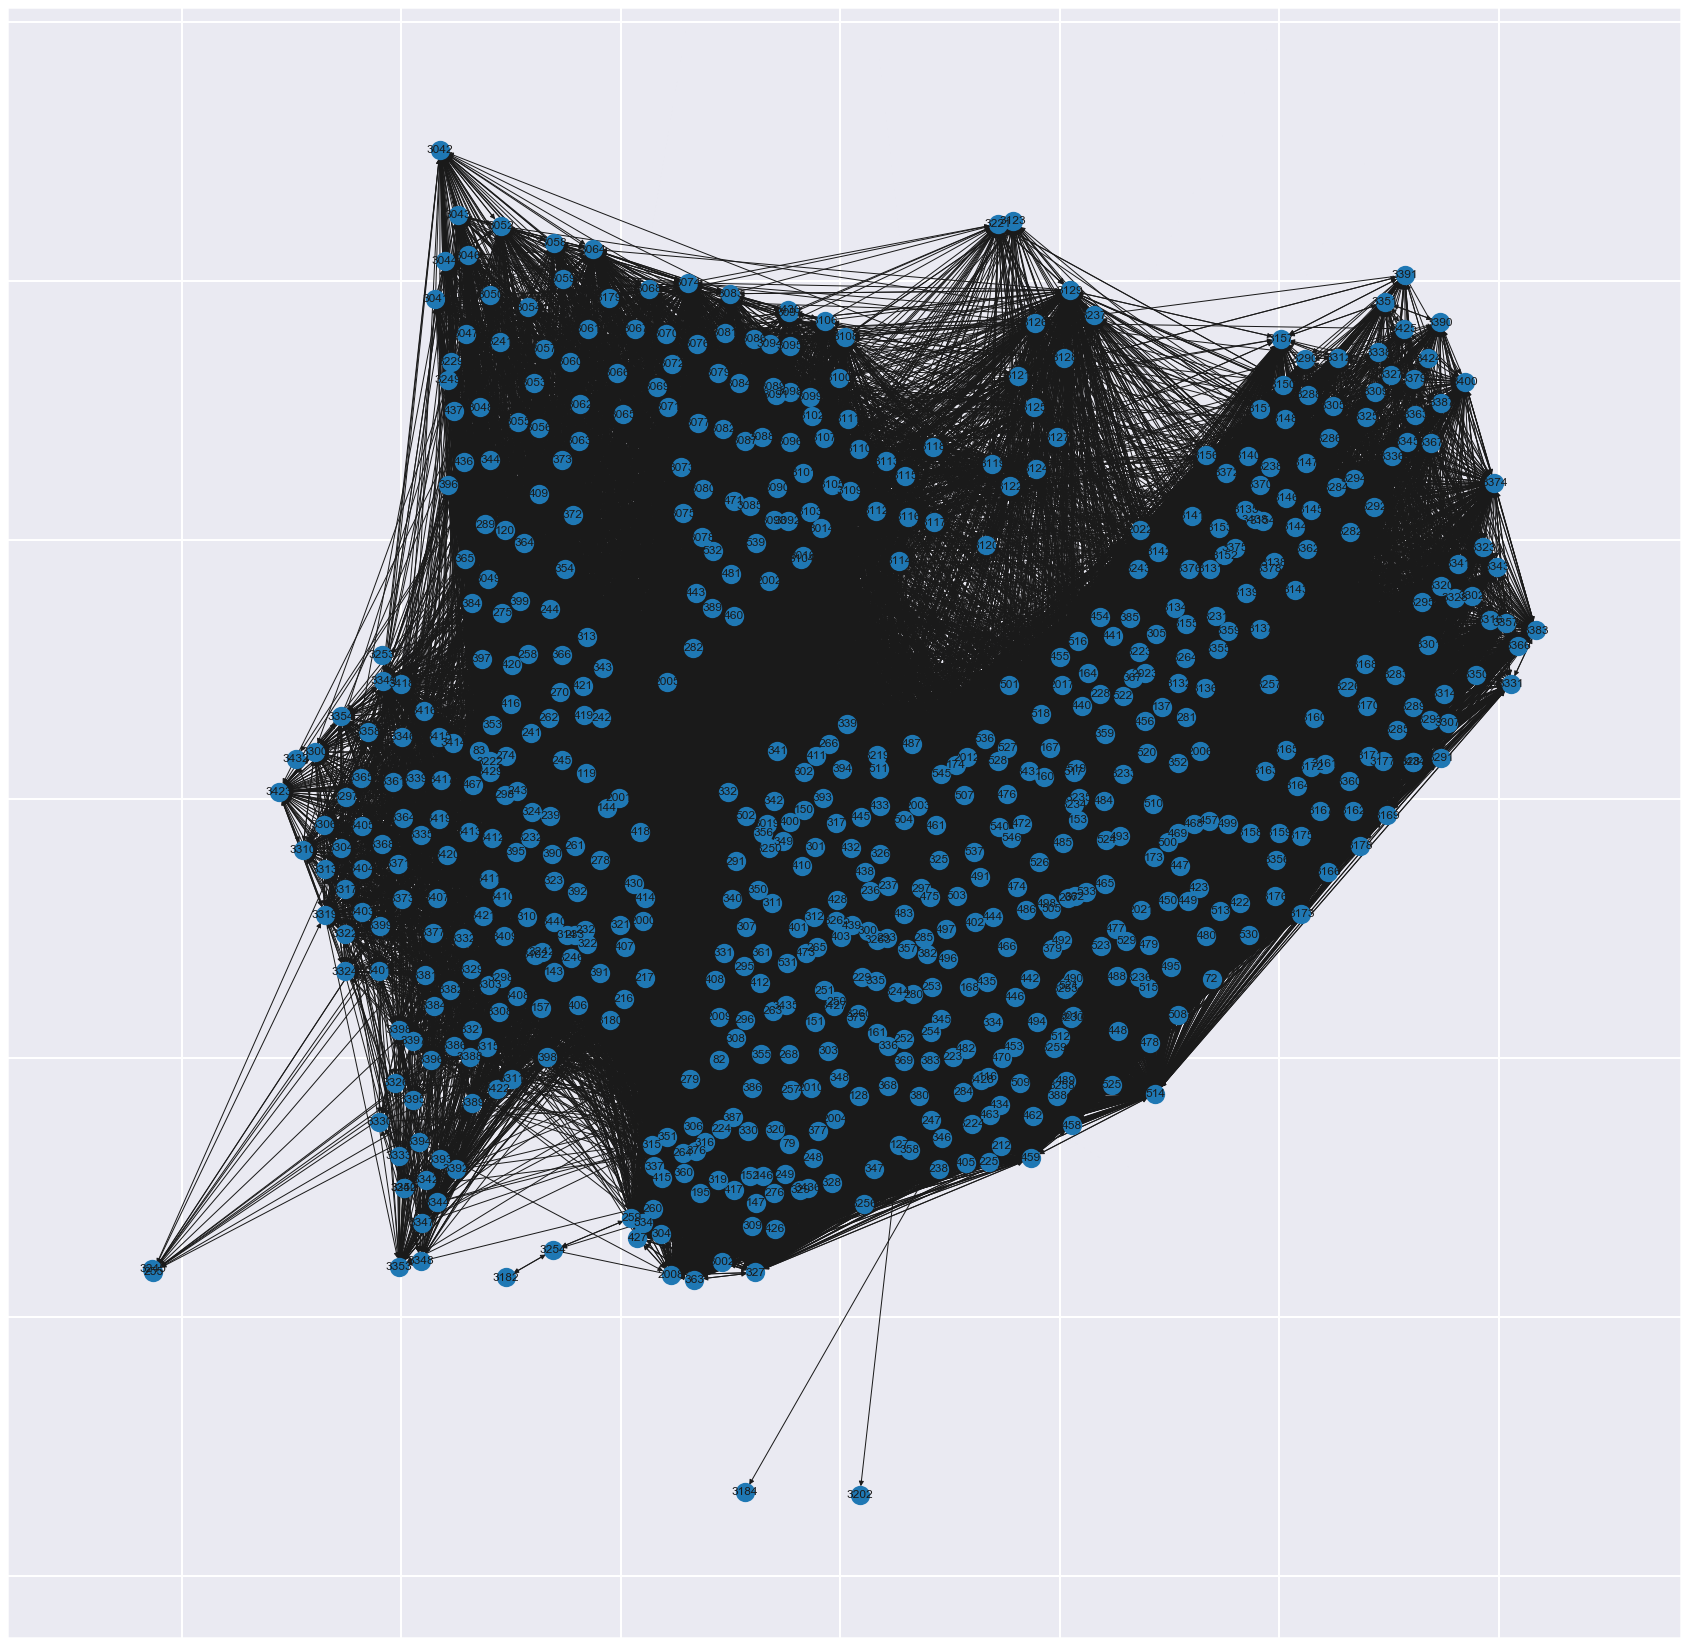

In [11]:
G = nx.DiGraph()
G.add_nodes_from(nodes_pos)
G.add_edges_from(edges)
# nx.set_node_attributes(G, nodes_pos)

#pos = nx.spring_layout(G, scale=0.5, k=0.5)
fig, ax = plt.subplots(figsize=(30,30))
nx.draw_networkx(G, ax=ax, pos=nodes_pos)
plt.show()

### Plot topN nodes

In [13]:
centrality_indegree = nx.in_degree_centrality(G)
sorted_stations = sorted(centrality_indegree.items(),
                         key=lambda x: x[1],
                         reverse=True)

N = 30
top_stations = set([x[0] for x in sorted_stations[0:N]])

nodes_topN = {key: value for (key,value) 
               in nodes_pos.items() 
               if key in top_stations}

edges_topN = [tuple for tuple 
               in edges 
               if (tuple[0] in top_stations) & 
               (tuple[1] in top_stations)]

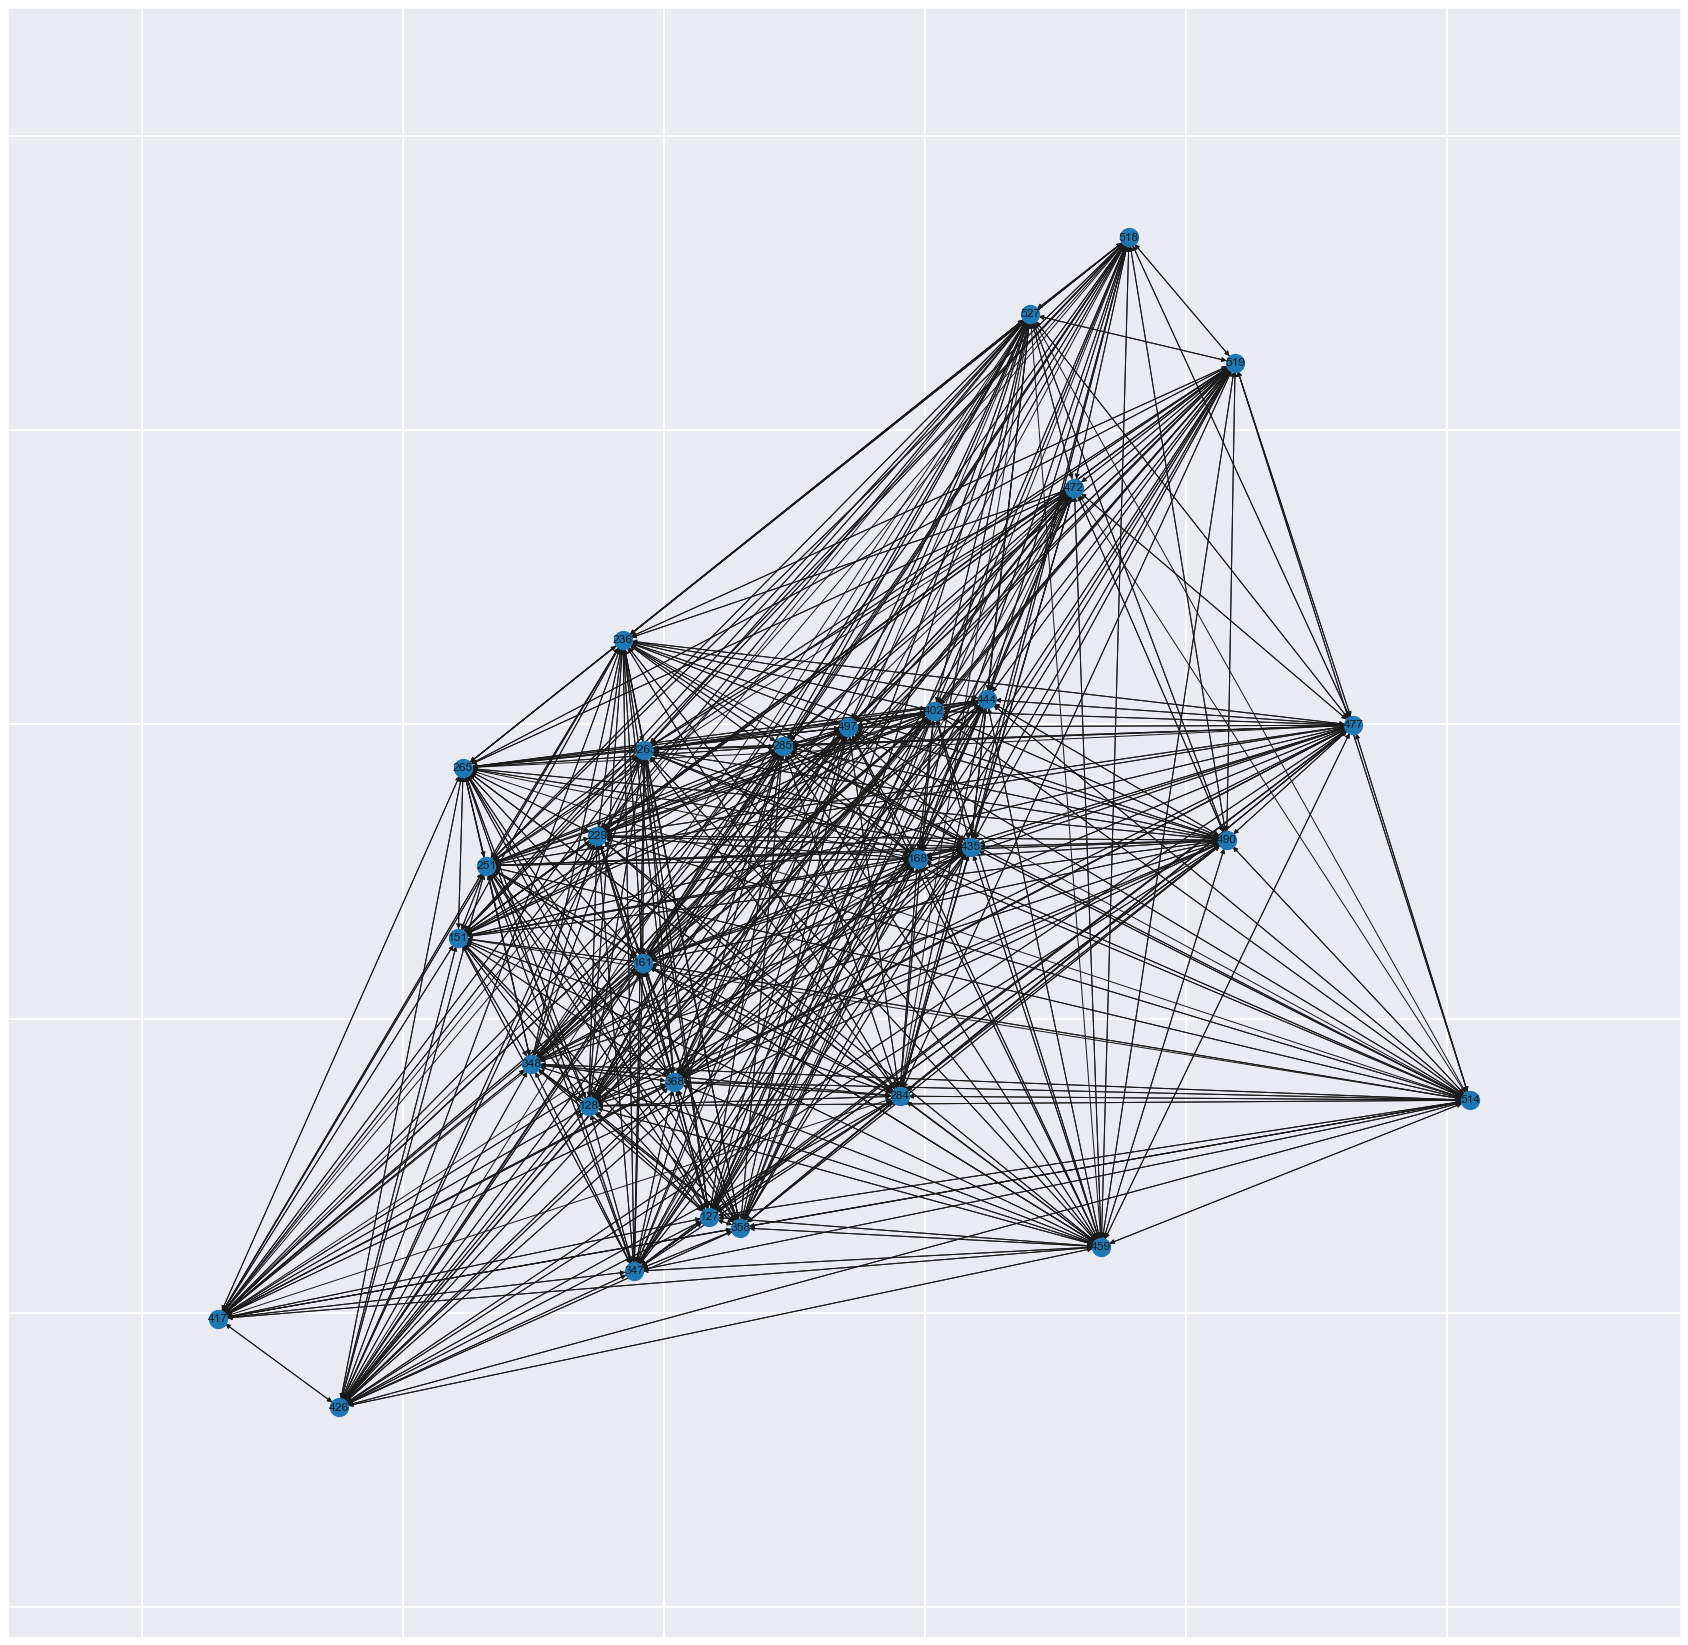

In [17]:
H = nx.DiGraph()
H.add_nodes_from(nodes_topN)
H.add_edges_from(edges_topN)
# nx.set_node_attributes(G, nodes_pos)

#pos = nx.spring_layout(G, scale=0.5, k=0.5)
fig, ax = plt.subplots(figsize=(30,30))
nx.draw_networkx(H, ax=ax, pos=nodes_topN)
plt.show()

In [18]:
print(f"{nx.info(H)}")

Name: 
Type: DiGraph
Number of nodes: 30
Number of edges: 868
Average in degree:  28.9333
Average out degree:  28.9333


In [20]:
# Tu: Plot networkx graph on map of New York City

## Analyze the network

In [ ]:
print(f"{nx.info(G)}")

In [ ]:
density = nx.density(G)
clustering_coefficient = nx.average_clustering(G)
centrality_indegree = nx.in_degree_centrality(G)

In [ ]:
stations.columns

For directed networks, there are two measures of degree. In-degree is the number of connections that point inward at a vertex. Out-degree is the number of connections that originate at a vertex and point outward to other vertices.

In [ ]:
# G.number_of_nodes()
# G.number_of_edges()

# in degree -> end station (return)
# out degree -> start station (pick-up)
# out degree - in degree => different colors

In [ ]:
## notice that there're self-loops
#print(G.edges(data = True)[:4])
#print()
#
## examine the density (the proportion of nodes that are connected)
#num_edges = len(G.edges())
#num_possible_edges = len(G.nodes()) ** 2
#density = num_edges / num_possible_edges
#print('density:', density)

In [ ]:
# basic descriptives
# density

In [ ]:
sorted_stations = sorted(centrality_indegree.items(),
                         key=lambda x: x[1],
                         reverse=True)
top10_stations = set([x[0] for x in sorted_stations[0:10]])
top10_stations

### Basic concepts and definitions
- adjacency matrix
- paths
- connected components

* Centrality measures
    * degree
    * closeness
    * pagerank
    * betweenness

In [ ]:
# Creating a list of degree, closeness, pagerank and betweenness centrality
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
pagerank = nx.pagerank(G, weight="weight")
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

centrality_measures = [
    degree_centrality, closeness_centrality, pagerank, betweenness_centrality
]

In [ ]:
df_centrality_measures = pd.DataFrame.from_records(
    centrality_measures).T.rename(columns={
        0: "degree",
        1: "closeness",
        2: "pagerank",
        3: "betweenness"
    })
df_centrality_measures.head(30)

In [ ]:
# pearson correlation between centrality measures
df_centrality_measures_corr = df_centrality_measures.corr()
df_centrality_measures_corr.replace(1,0)

In [ ]:
# heatmap of pearson correlations between centrality measures
sns.set(context="poster")
cmap = sns.cm.vlag
sns.heatmap(df_centrality_measures_corr, vmin=0, vmax=1, cmap=cmap)
plt.show()

* Structural features of social networks
    * heterogeneity
    * assortativity
    * clustering
    * small world
    * (communities)
* Network models
    * random graphs
    * generative models

In [ ]:
# graph plot, weight = counts / duration
# graph dependend on week day (Mo-Fr vs. Sa-Su) / season (summer vs winter)

In [ ]:
# References:
# https://www.kaggle.com/mmmarchetti/game-of-thrones-network-analysis
# https://campus.datacamp.com/courses/introduction-to-network-analysis-in-python/introduction-to-networks?ex=4
# http://ethen8181.github.io/machine-learning/networkx/networkx.html